In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/MachineLearning/PlantIll/"
base_dir = root_dir + 'DPModel'

In [3]:
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8MB 28kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline 

In [0]:
#change directory to where we have our project
import os 
os.getcwd() 
os.chdir('/content/gdrive/My Drive/MachineLearning/PlantIll') 

# Getting the data

In [0]:
## our datapath
path = Path('/content/gdrive/My Drive/Datasets/PlantVillage')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/models'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/tmp.pth')]

In [0]:
##### Data **augmentation** 
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src  = ImageList.from_folder(path)

In [11]:
src.items[3]

PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val/Apple___Cedar_apple_rust/e21f859e-9fee-43ee-a1ca-722c55885ad2___FREC_C.Rust 3852.JPG')

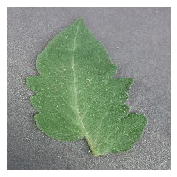

In [12]:
src[110].show()

In [13]:
sd = (src.split_by_folder(train='train', valid='val'))
sd

ItemLists;

Train: ImageList (26022 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: ImageList (6463 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [14]:
labellists =(sd.label_from_folder())
labellists

LabelLists;

Train: LabelList (26022 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Orange___Haunglongbing_(Citrus_greening),Orange___Haunglongbing_(Citrus_greening),Orange___Haunglongbing_(Citrus_greening),Orange___Haunglongbing_(Citrus_greening),Orange___Haunglongbing_(Citrus_greening)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: LabelList (6463 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [0]:
##batch size 
bs= 64
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256//2

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

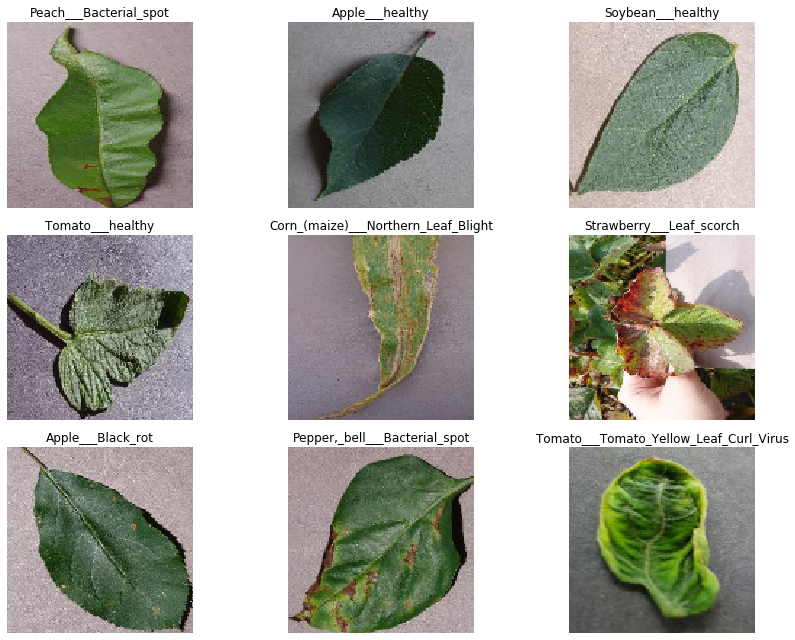

In [18]:
data.show_batch(rows=3, figsize=(12,9))

In [19]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

# Our Model 

In [20]:
## fbeta is F1 score fbeta,
learn = cnn_learner(data, models.vgg16_bn, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:11<00:00, 49628577.30it/s]


beta determines the value of the fbeta applied, eps is there for numeric stability. If sigmoid=True, a sigmoid is applied to the predictions before comparing them to thresh then to the targets. See the https://en.wikipedia.org/wiki/F1_score for details on the fbeta score.

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [64, 128, 128]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
___________________________________________________

# Train the model

In [22]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.956758,0.912480,0.820207,1:28:03
1,5.090214,3.617352,0.836454,04:06
2,4.318438,1.934116,0.907009,04:05
3,2.417502,6.579978,0.930682,04:05
4,1.080878,0.448641,0.954820,04:06
5,0.431927,0.139031,0.975089,04:04
6,0.253929,0.223979,0.980814,04:05


In [0]:
learn.save('weight-vgg16_bn-1')

Plotting Losses


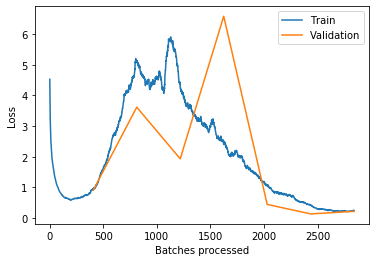

In [24]:
print("Plotting Losses")
learn.recorder.plot_losses()


Plotting metrics


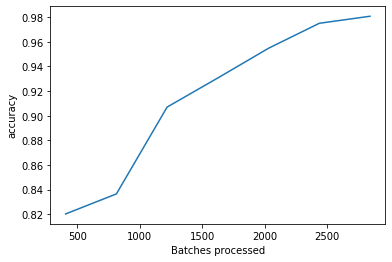

In [25]:
print("Plotting metrics")
learn.recorder.plot_metrics()


Plotting LR


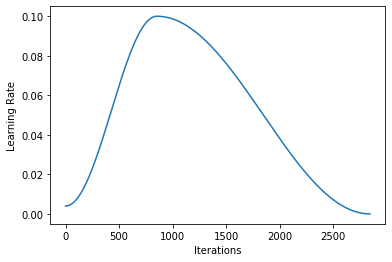

In [26]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('weight-vgg16_bn-1');

In [0]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,1.647071,8.040720,0.483057,04:56
1,4.291729,2.632293,0.625561,04:52
2,3.740521,268.683319,0.627418,04:52
3,1.825570,43.456520,0.752901,04:52
4,0.661717,0.306282,0.930373,04:53
5,0.222735,2.167065,0.951725,04:53
6,0.135323,2.861334,0.974934,04:54


In [0]:
learn.save('weight-vgg16_bn-2')

In [0]:
#before we start the last phase of training we change img_size = 256//2 to img_size = 256
# this change is called progrissive resizing in fastai this method helps
# the model to learn and get a better accuracy 

In [0]:
##batch size 
bs= 64
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 256

In [0]:
labellists = (labellists.transform(tfms , size=img_size))
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.vgg16_bn, metrics=[accuracy])

In [0]:
learn.load('weight-vgg16_bn-2');

In [0]:
learn.summary()

In [37]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.709328,5.866045,0.886895,20:45
1,3.757893,18.099239,0.769612,22:24
2,3.348962,90.116714,0.852700,22:21
3,1.911021,2.693940,0.927124,22:18
4,0.683529,17.027760,0.954356,22:20
5,0.310819,1.216295,0.971221,22:15
6,0.142921,1.633502,0.976791,22:07


In [0]:
learn.save('weight-vgg16_bn-3')

In [0]:
learn.load('weight-vgg16_bn-3');

In [40]:
learn.freeze_to(-3)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.815224,137.874161,0.832276,29:12
1,4.310106,19.067598,0.832431,29:36
2,2.639149,31.393391,0.900511,29:33
3,1.948156,133.469650,0.923720,29:18
4,0.752899,15.299699,0.960390,29:16
5,0.245601,2.605063,0.983135,29:24
6,0.098671,5.553330,0.987003,29:27


In [0]:
learn.save('weight-vgg16_bn-4')

In [0]:
learn.load('weight-vgg16_bn-4');

In [43]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.708200,35.301624,0.921708,29:22
1,3.782966,57.470093,0.868018,29:14
2,3.182942,5.467014,0.912270,29:15
3,1.647984,12.796496,0.923410,29:16
4,0.716445,1.998255,0.964877,29:16
5,0.217165,0.858200,0.984837,29:16
6,0.144616,0.117362,0.986694,29:17


In [0]:
learn.save('weight-vgg16_bn-5')

Plotting Losses


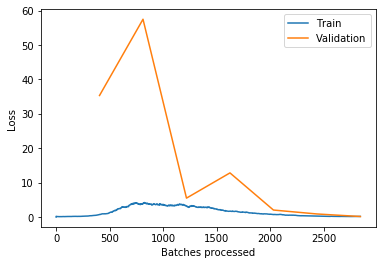

In [45]:
print("Plotting Losses")
learn.recorder.plot_losses()

Plotting metrics


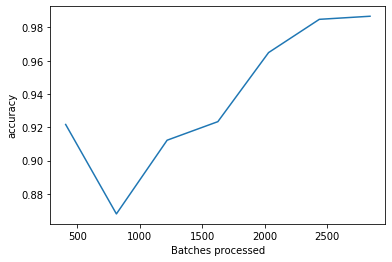

In [46]:
print("Plotting metrics")
learn.recorder.plot_metrics()

Plotting LR


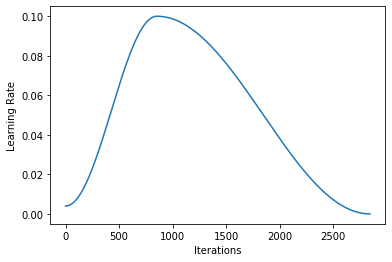

In [47]:
print("Plotting LR")
learn.recorder.plot_lr()